<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/EECE5644_Assgn1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [ ]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)

    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)
        labels[indices] = l * np.ones(Nl) - 1
        # If dealing with a univariate Gaussian, use norm.rvs to sample RVs and not the multivariate version
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)

    return X, labels

In [ ]:
n = 3 # dimensionality of input random vectors
C = 3 # number of classes

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.3,0.3, 0.4])

# Set mean vectors to be equally spaced out along a line in order
gmm_pdf['mu'] = np.array([1*np.ones(n), 2*np.ones(n), 3*np.ones(n)])

# Set covariance matrices so that there is significant overlap between these
# distributions with means given above
gmm_pdf['Sigma'] = np.array([3*np.eye(n), 3*np.eye(n), 3*np.eye(n)])

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

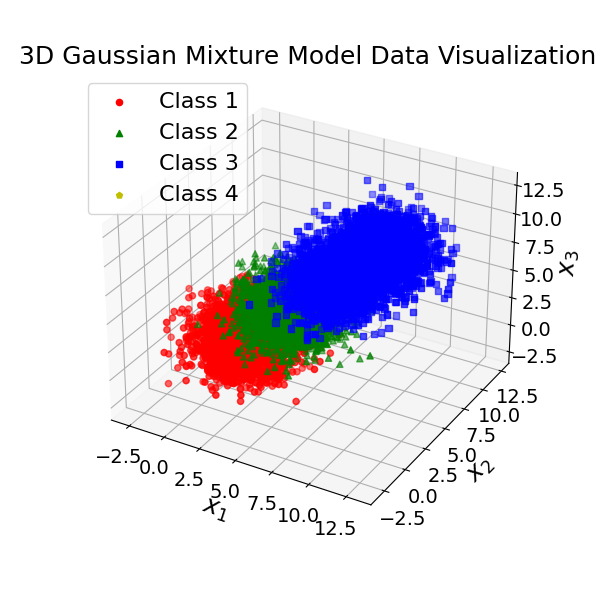

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

n = 3  # Dimensionality increased to 3
C = 4  # Number of classes

# Class priors
priors = np.array([0.3, 0.3, 0.4, 0])  # Adjusted priors, fourth is zero since it's a mix in class 3

# Define mean vectors along a line
mean_distance = 2  # Define a distance factor
mu = np.array([1*np.ones(n), 2*np.ones(n), 3*np.ones(n), 4*np.ones(n)]) * mean_distance

# Define covariance matrices with significant overlap
scale_factor = 2  # Adjust scale to manage overlap
Sigma = np.array([scale_factor*np.eye(n), scale_factor*np.eye(n), scale_factor*np.eye(n), scale_factor*np.eye(n)])

# Function to generate data from GMM
def generate_data_from_gmm(N, priors, mu, Sigma):
    X = np.zeros((N, n))
    labels = np.zeros(N, dtype=int)
    cumulative_priors = np.cumsum(priors)
    for i in range(N):
        p = np.random.rand()
        class_label = np.where(cumulative_priors >= p)[0][0]
        if class_label == 2:  # For class 3, choose between the two components
            component = np.random.choice([2, 3], p=[0.5, 0.5])  # Equal weight for the mixture components
            X[i, :] = multivariate_normal.rvs(mean=mu[component], cov=Sigma[component])
        else:
            X[i, :] = multivariate_normal.rvs(mean=mu[class_label], cov=Sigma[class_label])
        labels[i] = class_label
    return X, labels

N = 10000  # Number of samples
X, labels = generate_data_from_gmm(N, priors, mu, Sigma)

# Visualizing the data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']  # Colors for each class
markers = ['o', '^', 's', 'p']  # Different markers for visualization

for l in range(C):
    idx = labels == l
    ax.scatter(X[idx, 0], X[idx, 1], X[idx, 2], c=colors[l], marker=markers[l], label=f'Class {l+1}')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.title("3D Gaussian Mixture Model Data Visualization")
plt.legend()
plt.show()


In [ ]:
# Count the number of samples per class
counts_per_class = np.bincount(labels, minlength=C)
print("Number of samples per class:", counts_per_class)

Number of samples per class: [2941 3087 3972    0]


In [ ]:
from scipy.stats import multivariate_normal

def map_classifier(X, priors, mu, Sigma):
    N = X.shape[0]
    C = len(priors)
    posterior_probs = np.zeros((N, C))

    for c in range(C):
        # Calculate the likelihood of each sample under each class
        likelihood = multivariate_normal.pdf(X, mean=mu[c], cov=Sigma[c])
        # Calculate the posterior probability for class c
        posterior_probs[:, c] = likelihood * priors[c]

    # Determine the class with the maximum posterior probability
    classified_labels = np.argmax(posterior_probs, axis=1)
    return classified_labels

# Example usage of the classifier
classified_labels = map_classifier(X, priors, mu, Sigma)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, classified_labels)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[2604  335    2]
 [ 344 2346  397]
 [   0  187 3785]]


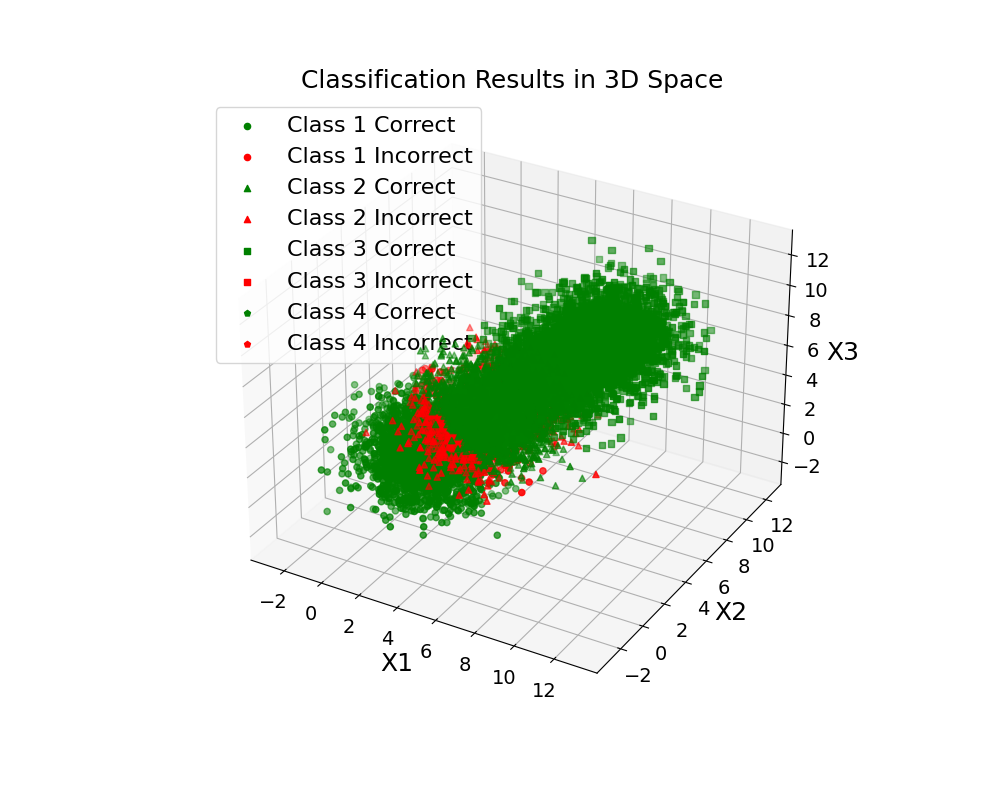

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define marker shapes and colors for each class
markers = ['o', '^', 's', 'p']  # Different shapes for each class
colors = ['red', 'blue', 'green', 'yellow']  # Colors assigned to each class

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample
for i in range(len(priors)):
    # Indices for the true class i
    idx = labels == i
    # Indices for correct and incorrect classification
    correct = classified_labels == labels
    incorrect = classified_labels != labels

    # Apply both conditions, correct indexing for true class i and classification correctness
    ax.scatter(X[(idx) & (correct), 0], X[(idx) & (correct), 1], X[(idx) & (correct), 2],
               c='green', marker=markers[i], label=f'Class {i+1} Correct')
    ax.scatter(X[(idx) & (incorrect), 0], X[(idx) & (incorrect), 1], X[(idx) & (incorrect), 2],
               c='red', marker=markers[i], label=f'Class {i+1} Incorrect')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Classification Results in 3D Space')
ax.legend(loc='upper left')
plt.show()


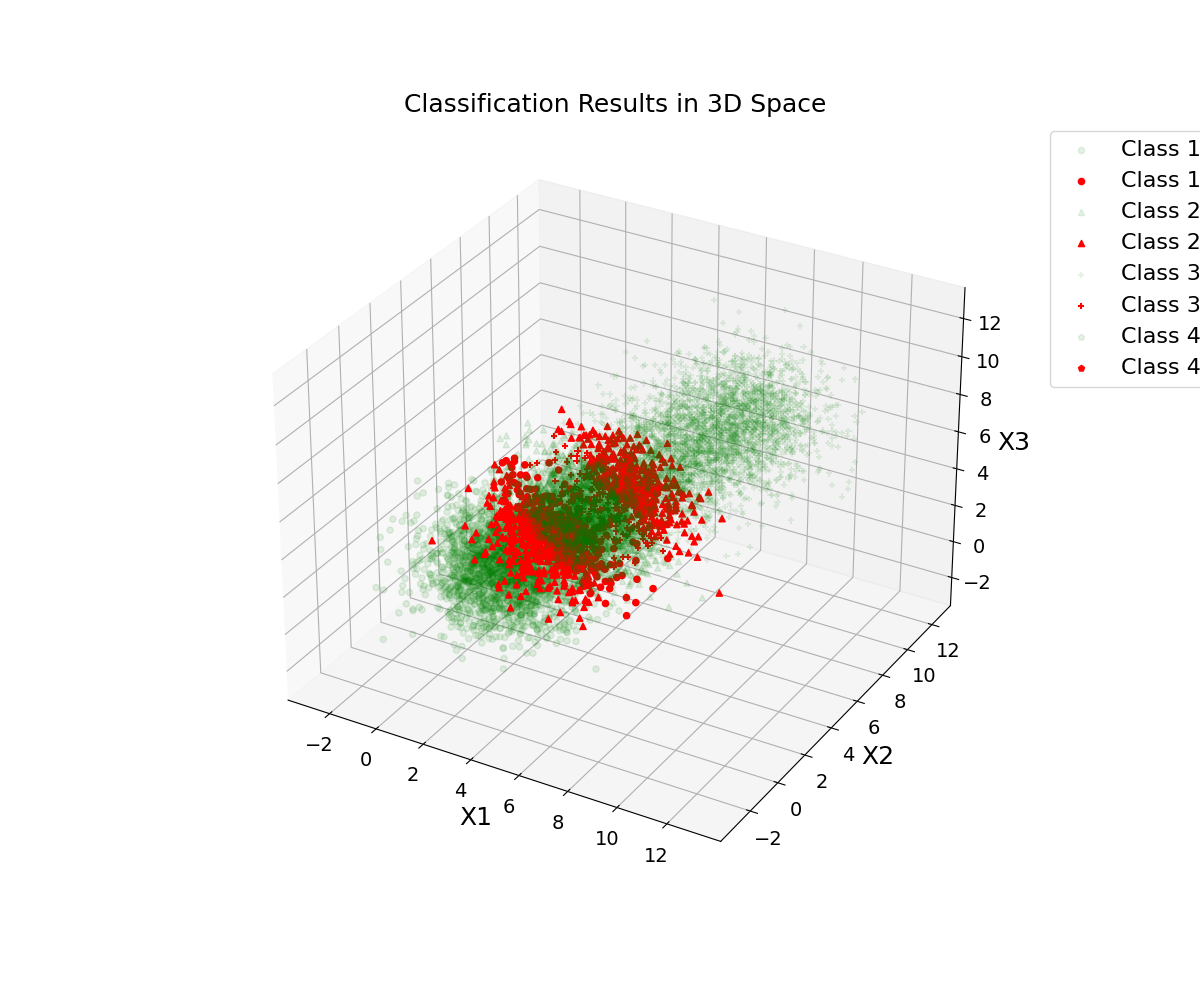

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define marker shapes and colors for each class
markers = ['o', '^', '+', 'p']  # Different shapes for each class
colors = ['red', 'blue', 'green', 'yellow']  # Colors assigned to each class

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample
for i in range(len(priors)):
    # Indices for the true class i
    idx = labels == i
    # Indices for correct and incorrect classification
    correct = classified_labels == labels
    incorrect = classified_labels != labels

    # Apply both conditions, correct indexing for true class i and classification correctness
    # Correct classified samples with alpha = 0.5
    ax.scatter(X[(idx) & (correct), 0], X[(idx) & (correct), 1], X[(idx) & (correct), 2],
               c='green', marker=markers[i], label=f'Class {i+1} Correct', alpha=0.1)

    # Incorrect classified samples with alpha = 1
    ax.scatter(X[(idx) & (incorrect), 0], X[(idx) & (incorrect), 1], X[(idx) & (incorrect), 2],
               c='red', marker=markers[i], label=f'Class {i+1} Incorrect', alpha=1)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Classification Results in 3D Space')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

def generate_data_from_gmm(N, priors, mu, Sigma):
    n = mu.shape[1]  # Assuming dimensionality from mean vectors, should be 3
    C = len(priors)  # Number of classes
    X = np.zeros((N, n))
    labels = np.zeros(N, dtype=int)

    # Generate data
    for i in range(N):
        p = np.random.rand()
        # Find the class based on the cumulative sum of priors
        class_label = np.searchsorted(np.cumsum(priors), p)
        # Handle edge case where class_label equals the number of classes
        class_label = min(class_label, C - 1)

        # For the mixture class, choose randomly between its Gaussian components
        if class_label == 2:  # Assuming class 3 is a mixture of two components
            component = np.random.choice([2, 3])  # Adjust if your component indices are different
            X[i, :] = multivariate_normal.rvs(mean=mu[component], cov=Sigma[component])
        else:
            X[i, :] = multivariate_normal.rvs(mean=mu[class_label], cov=Sigma[class_label])
        labels[i] = class_label

    return X, labels

# Example parameters
N = 10000
C = 4
priors = np.array([0.25, 0.25, 0.25, 0.25])  # Adjust these priors as needed
mu = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])  # Mean vectors for 3D
Sigma = np.array([np.eye(3) * 1 for _ in range(4)])  # Identity matrices scaled by 1 for simplicity

# Generate data
X, labels = generate_data_from_gmm(N, priors, mu, Sigma)

# Define two loss matrices as specified
Lambda_10 = np.array([[0, 1, 10],
                      [1, 0, 10],
                      [1, 1, 0]])

Lambda_100 = np.array([[0, 1, 100],
                       [1, 0, 100],
                       [1, 1, 0]])

# Perform ERM classification for each loss matrix
def perform_erm_classification(X, Lambda, priors, mu, Sigma):
    N, n = X.shape
    risks = np.zeros((N, C))
    for c in range(C):
        likelihood = multivariate_normal.pdf(X, mean=mu[c], cov=Sigma[c])
        # Compute risk for each class
        for dc in range(C):
            # Risk is the product of the loss matrix entry and the likelihood of the data given the class
            risks[:, dc] += Lambda[dc, c] * likelihood * priors[c]
    return np.argmin(risks, axis=1)

# Classification with Lambda_10
decisions_10 = perform_erm_classification(X, Lambda_10, priors, mu, Sigma)
conf_mat_10 = confusion_matrix(labels, decisions_10)
print("Confusion Matrix with Lambda_10:")
print(conf_mat_10)

# Classification with Lambda_100
decisions_100 = perform_erm_classification(X, Lambda_100, priors, mu, Sigma)
conf_mat_100 = confusion_matrix(labels, decisions_100)
print("Confusion Matrix with Lambda_100:")
print(conf_mat_100)

# Visualization of classification results for one scenario (e.g., Lambda_10)
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red']
markers = ['o', '^', 's']

for i in range(C):
    # Filtering correct and incorrect classifications for visualization
    correct_idx = (labels == i) & (decisions_10 == i)
    incorrect_idx = (labels == i) & (decisions_10 != i)
    ax.scatter(X[correct_idx, 0], X[correct_idx, 1], color=colors[i], marker=markers[i], label=f'Class {i+1} Correct')
    ax.scatter(X[incorrect_idx, 0], X[incorrect_idx, 1], color='gray', marker=markers[i], label=f'Class {i+1} Incorrect')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('ERM Classification Results with Lambda_10')
ax.legend()
plt.show()

# Discussion of results and insights


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

def perform_erm_classification(X, Lambda, priors, mu, Sigma):
    N, n = X.shape
    C = len(priors)  # Ensure C is derived from the length of priors which should match Lambda dimensions
    risks = np.zeros((N, C))

    for c in range(C):
        likelihood = multivariate_normal.pdf(X, mean=mu[c], cov=Sigma[c])
        # Compute risk for each class decision
        for dc in range(C):
            # Check the dimensions of Lambda to ensure they match
            risks[:, dc] += Lambda[dc, c] * likelihood * priors[c]

    # Return the index of the minimum risk decision for each sample
    return np.argmin(risks, axis=1)

# Assuming 4 classes as per your scenario
C = 4
N = 10000
priors = np.array([0.25, 0.25, 0.25, 0.25])
mu = np.array([np.random.rand(3) for _ in range(C)])
Sigma = np.array([np.eye(3) for _ in range(C)])
Lambda = np.array([[0, 1, 2, 3],
                   [1, 0, 1, 2],
                   [2, 1, 0, 1],
                   [3, 2, 1, 0]])

# Generate data using your generate_data_from_gmm function or equivalent
X, labels = generate_data_from_gmm(N, priors, mu, Sigma)  # Ensure this function is correctly generating labels and X

# Classification
decisions = perform_erm_classification(X, Lambda, priors, mu, Sigma)
conf_mat = confusion_matrix(labels, decisions)
print("Confusion Matrix:")
print(conf_mat)


Confusion Matrix:
[[  55 1607  804   19]
 [  34 1563  864   27]
 [   6  802 1575  129]
 [   8  866 1479  162]]


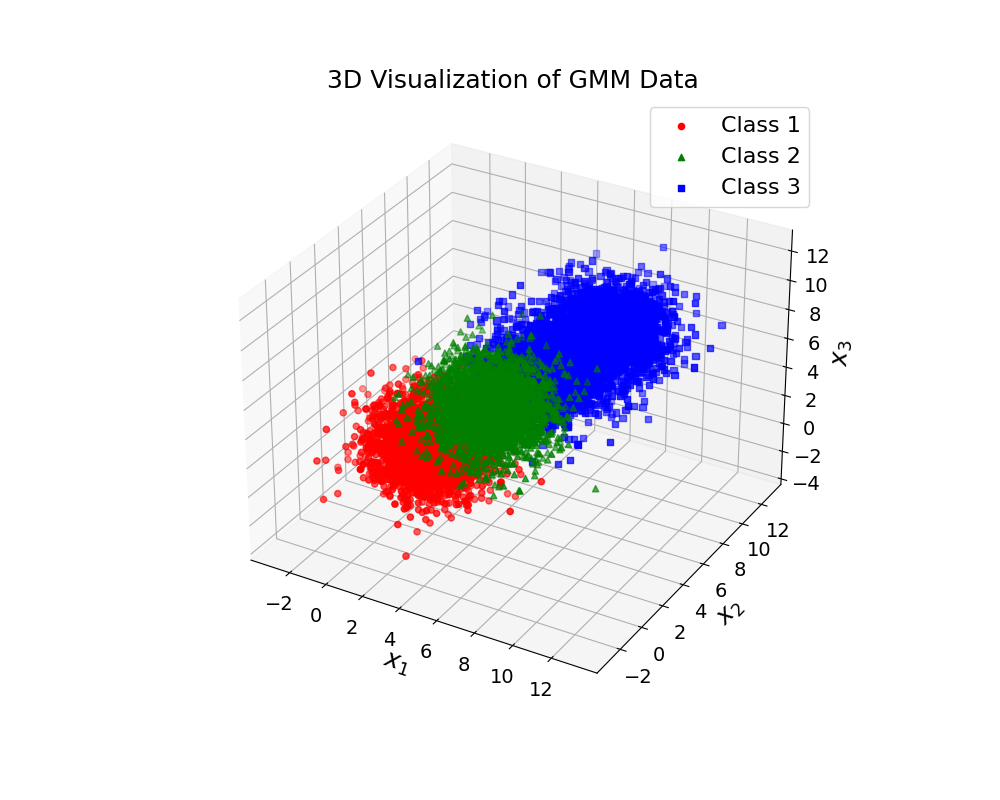

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

def generate_data_from_gmm(N, gmm_pdf):
    n = gmm_pdf['mu'].shape[1]  # dimensionality of vectors
    X = np.zeros((N, n))
    labels = np.zeros(N, dtype=int)

    # Decide randomly which samples will come from each component
    # Uniform distribution to decide the class based on cumulative prior thresholds
    u = np.random.rand(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # Insert 0 at the start for proper interval comparison

    # Loop over each class to allocate samples
    for i in range(len(gmm_pdf['priors'])):
        # Find indices of samples that fall into the current class interval
        indices = np.where((u > thresholds[i]) & (u <= thresholds[i + 1]))[0]
        if i == 2:  # Special handling for class 3 which is a mixture of two components
            # Half of the indices for one component, half for the other
            half = len(indices) // 2
            first_half = indices[:half]
            second_half = indices[half:]

            # Generate samples from the two sub-components for class 3
            X[first_half, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][2], cov=gmm_pdf['Sigma'][2], size=len(first_half))
            X[second_half, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][3], cov=gmm_pdf['Sigma'][3], size=len(second_half))
            labels[indices] = 2  # All get class label 2
        else:
            # Generate samples for this class from its corresponding Gaussian component
            X[indices, :] = multivariate_normal.rvs(mean=gmm_pdf['mu'][i], cov=gmm_pdf['Sigma'][i], size=len(indices))
            labels[indices] = i

    return X, labels

# Standard deviation for the Gaussian components
std_dev = 2  # Standard deviation value

# Configuration for the GMM
gmm_pdf = {
    'priors': np.array([0.3, 0.3, 0.4]),  # Adjusted priors to sum to 1
    'mu': np.array([i * std_dev * np.ones(3) for i in range(1, 5)]),  # Calculated means based on the standard deviation
    'Sigma': np.array([np.eye(3) * std_dev for _ in range(4)])  # Covariance matrices scaled by the standard deviation
}

N = 10000
X, labels = generate_data_from_gmm(N, gmm_pdf)

# Plot the generated data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']  # Colors for the three classes
markers = ['o', '^', 's']  # Markers for the three classes

for i in range(3):  # Three classes (0, 1, 2)
    ax.scatter(X[labels == i, 0], X[labels == i, 1], X[labels == i, 2],
               color=colors[i], marker=markers[i], label=f'Class {i+1}')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.title('3D Visualization of GMM Data')
plt.legend()
plt.show()


Here, decision rule for min-prob errror

In [ ]:
# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)

    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 1227
Empirically Estimated Probability of Error: 0.1227


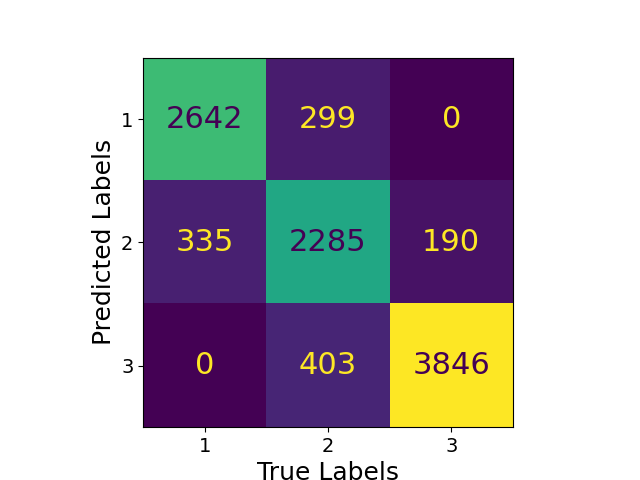

In [ ]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

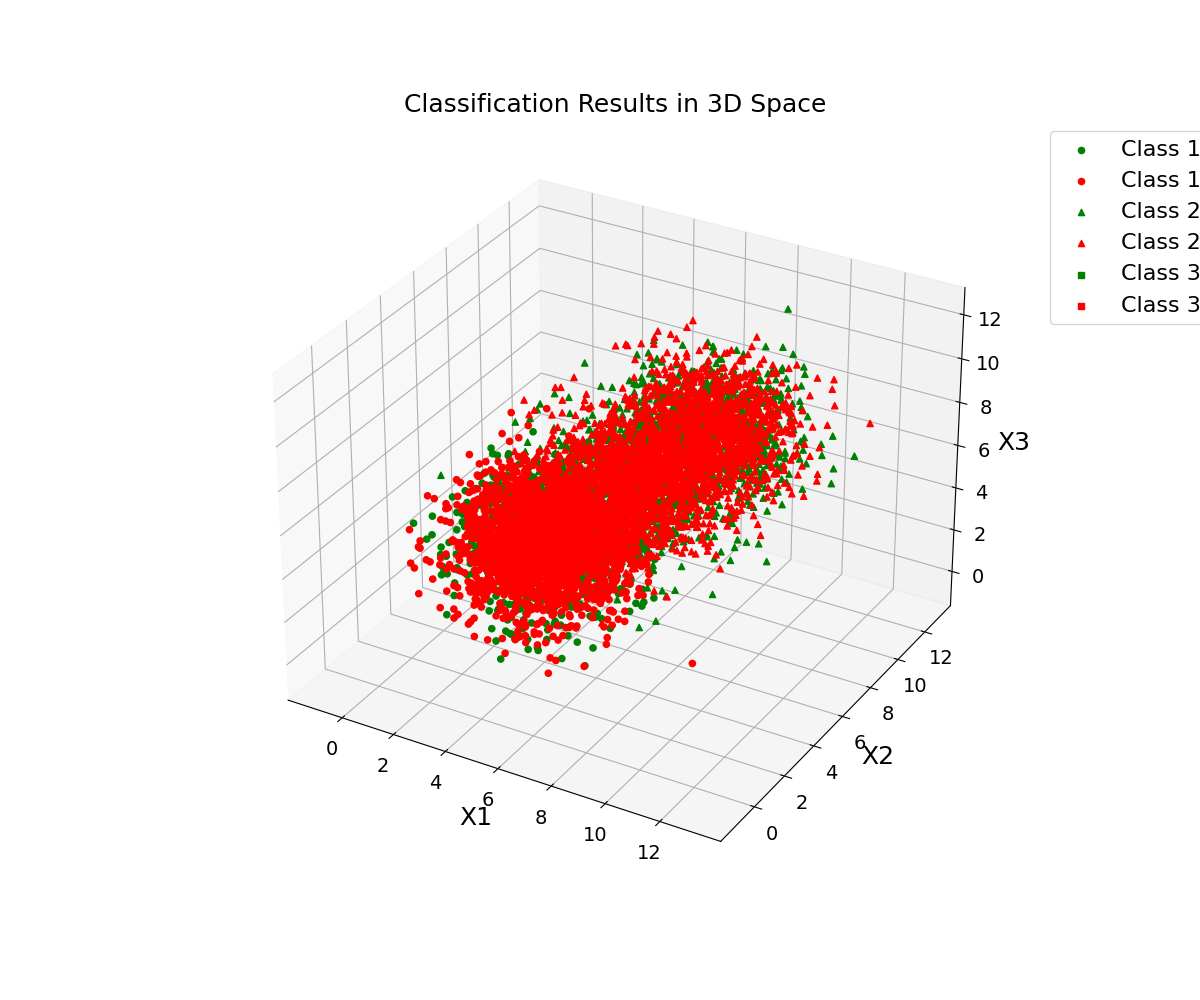

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define marker shapes and colors for each class
markers = ['o', '^', 's']  # Different shapes for each class
colors = ['red', 'blue', 'green']  # Colors assigned to each class

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot each sample
for i in range(C):
    # Indices for the true class i
    idx = labels == i + 1
    # Indices for correct and incorrect classification
    correct = classified_labels == labels
    incorrect = classified_labels != labels

    # Apply both conditions, correct indexing for true class i and classification correctness
    # Correct classified samples with alpha = 0.5
    ax.scatter(X[(idx) & (correct), 0], X[(idx) & (correct), 1], X[(idx) & (correct), 2],
               c='green', marker=markers[i], label=f'Class {i+1} Correct', alpha=1)

    # Incorrect classified samples with alpha = 1
    ax.scatter(X[(idx) & (incorrect), 0], X[(idx) & (incorrect), 1], X[(idx) & (incorrect), 2],
               c='red', marker=markers[i], label=f'Class {i+1} Incorrect', alpha=1)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Classification Results in 3D Space')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
# Define the loss matrices
Lambda_10 = np.array([[0, 1, 10],
                      [1, 0, 10],
                      [1, 1, 0]])

Lambda_100 = np.array([[0, 1, 100],
                       [1, 0, 100],
                       [1, 1, 0]])



Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 1977
Empirically Estimated Probability of Error: 0.1977


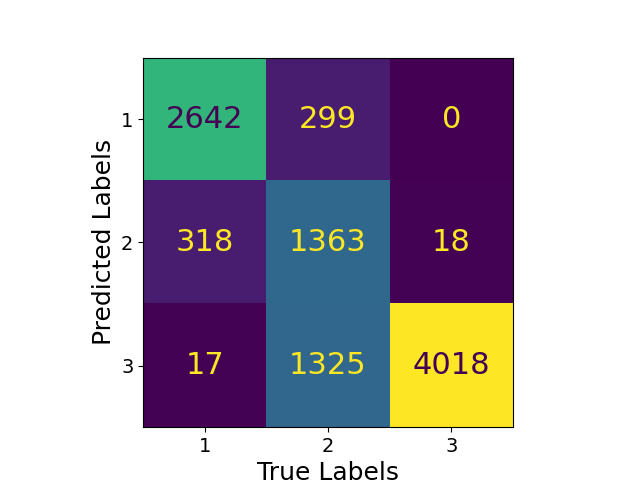

In [ ]:
# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions_10 = perform_erm_classification(X, Lambda_10, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions_10, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions_10, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))



Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 2978
Empirically Estimated Probability of Error: 0.2978


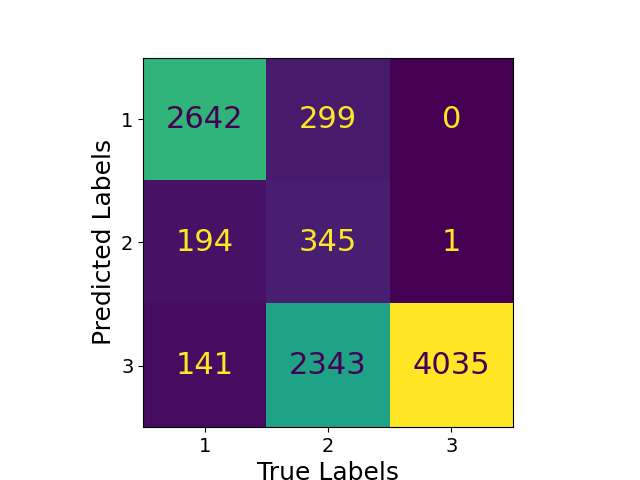

In [ ]:
decisions_100 = perform_erm_classification(X, Lambda_100, gmm_pdf, C)
# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions_100, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions_100, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
